# Part 3: Heuristic Policy

In [1]:
from abc import ABC, abstractmethod
from typing import Union

import gym
import numpy as np
import torch

np.random.seed(127)

In [2]:
class NormalizedEnv(gym.ActionWrapper):
    """Wrap action"""

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low) / 2.0
        act_b = (self.action_space.high + self.action_space.low) / 2.0
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2.0 / (self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low) / 2.0
        return act_k_inv * (action - act_b)


class Agent(ABC):
    @abstractmethod
    def compute_action(
        self, state: Union[np.ndarray, torch.Tensor]
    ) -> Union[np.ndarray, torch.Tensor]:
        pass


class RandomAgent(Agent):
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]

    def compute_action(self, state: np.ndarray):
        state = np.atleast_2d(state)
        return np.random.uniform(-1, 1, size=(state.shape[0], self.action_size))

In [3]:
env = NormalizedEnv(gym.make("Pendulum-v1"))

In [4]:
def run_episode(env, agent):
    state = env.reset()[0]
    trunc = False
    rewards = []
    while not trunc:
        if hasattr(agent, "policy_network"):
            state = torch.from_numpy(state).float()
        action = agent.compute_action(state)
        action = action[0, 0]
        if hasattr(agent, "policy_network"):
            action = action.item()
        state, reward, _, trunc, _ = env.step(action)
        rewards.append(reward)

    return rewards

In [5]:
rewards = run_episode(env, RandomAgent(env))
print("Total reward for a single episode with a random policy: ", np.sum(rewards))

Total reward for a single episode with a random policy:  -926.1351407502539


/Users/tudoroancea/miniforge3/envs/cs_456_project/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
mean_reward = np.mean([np.sum(run_episode(env, RandomAgent(env))) for _ in range(100)])
print("Mean reward over 100 episoded with a random policy: ", mean_reward)

Mean reward over 100 episoded with a random policy:  -1253.4588887307038


In [7]:
class HeuristicPendulumAgent(Agent):
    def __init__(self, torque1: float, torque2: float):
        self.torque1 = torque1
        self.torque2 = torque2

    def compute_action(self, state: np.ndarray):
        state = np.atleast_2d(state)
        return np.where(
            state[:, 0:1] < 0.0,
            self.torque1 * np.sign(state[:, 2:3]),
            -self.torque2 * np.sign(state[:, 2:3]),
        )

In [18]:
agent = HeuristicPendulumAgent(0.1, 0.1)
mean_reward = np.mean([np.sum(run_episode(env, agent)) for _ in range(100)])
print("Mean reward over 100 episodes with heuristic policy: ", mean_reward)

Mean reward over 100 episodes with heuristic policy:  -1035.2844883084188


In [19]:
agent = HeuristicPendulumAgent(0.25, 0.25)
mean_reward = np.mean([np.sum(run_episode(env, agent)) for _ in range(100)])
print("Mean reward over 100 episodes with heuristic policy: ", mean_reward)

Mean reward over 100 episodes with heuristic policy:  -830.4759995640879


In [20]:
agent = HeuristicPendulumAgent(0.5, 0.5)
mean_reward = np.mean([np.sum(run_episode(env, agent)) for _ in range(100)])
print("Mean reward over 100 episodes with heuristic policy: ", mean_reward)

Mean reward over 100 episodes with heuristic policy:  -569.371109371163


In [21]:
agent = HeuristicPendulumAgent(1.0, 1.0)
mean_reward = np.mean([np.sum(run_episode(env, agent)) for _ in range(100)])
print("Mean reward over 100 episodes with heuristic policy: ", mean_reward)

Mean reward over 100 episodes with heuristic policy:  -449.24700334189953


# Part 4: Q-function of the heuristic policy

In [22]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

# set all random seeds
np.random.seed(127)
torch.manual_seed(127)

# set matplotlib style
plt.style.use("science")
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 16

In [23]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(
        self,
        state: np.ndarray,
        action: np.ndarray,
        reward: float,
        next_state: np.ndarray,
        trunc: bool,
    ):
        self.buffer.append((state, action, reward, next_state, trunc))

    def sample(
        self, indices: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        states, actions, rewards, next_states, truncs = zip(
            *(self.buffer[idx] for idx in indices)
        )

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(truncs, dtype=bool),
        )

In [24]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        # intialize weights with xavier uniform and bias 0
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [25]:
def critic_learning_step_part4(
    actor: Agent,
    critic: QNetwork,
    batch: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    optimizer: torch.optim.Optimizer,
    gamma: float,
) -> float:
    states, actions, rewards, next_states, truncs = batch

    # compute the target
    with torch.no_grad():
        next_actions = actor.compute_action(next_states)
        next_q_values = critic(
            torch.from_numpy(np.hstack((next_states, next_actions))).float()
        ).squeeze()
        target = (
            torch.from_numpy(rewards).float()
            + gamma * next_q_values * ~torch.from_numpy(truncs).bool()
        )

    # compute q values using qnetwork
    q_values = critic(
        torch.from_numpy(np.hstack((states, actions.reshape(-1, 1)))).float()
    ).squeeze()

    # compute loss
    loss = F.mse_loss(q_values, target)

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train_qnetwork_part4(
    env: NormalizedEnv,
    agent: Agent,
    qnetwork: QNetwork,
    num_episodes=1000,
    batch_size=128,
    buffer_size=1e4,
    gamma=0.99,
    learning_rate=1e-4,
):
    buffer = ReplayBuffer(int(buffer_size))
    optimizer = optim.Adam(qnetwork.parameters(), lr=learning_rate)

    losses = []
    for _ in tqdm.trange(num_episodes):
        # run an episode with the agent
        state = env.reset()[0]
        trunc = False
        episode_losses = []
        while not trunc:
            action = agent.compute_action(state)
            action = action[0, 0]
            next_state, reward, _, trunc, _ = env.step(action)
            buffer.append(state, action, reward, next_state, trunc)
            state = next_state

            if len(buffer) < batch_size:
                continue

            # bootstrap the buffer
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            episode_losses.append(
                critic_learning_step_part4(
                    agent, qnetwork, buffer.sample(indices), optimizer, gamma
                )
            )

        losses.append(np.mean(episode_losses))

    return losses

In [26]:
qnetwork_part4 = QNetwork()
qnetwork_part4_before_training = QNetwork()
qnetwork_part4_before_training.load_state_dict(qnetwork_part4.state_dict())
critic_losses_part4 = train_qnetwork_part4(env, HeuristicPendulumAgent(1.0, 1.0), qnetwork_part4)

100%|██████████| 1000/1000 [01:21<00:00, 12.32it/s]


Text(0.5, 1.0, 'Loss part 4 (Q Network training with Heuristic Agent)')

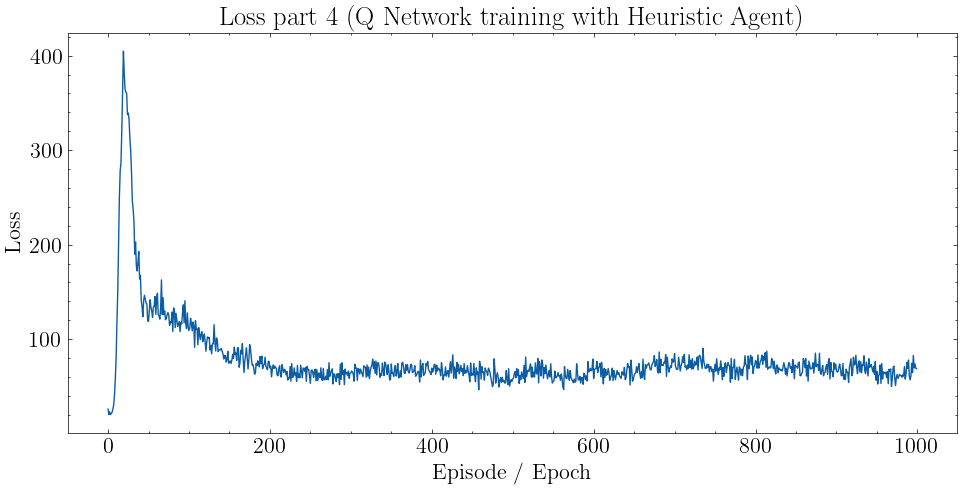

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(critic_losses_part4)
plt.xlabel("Episode / Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("figures/losses_part4.png", bbox_inches="tight", dpi=300)
plt.title("Loss part 4 (Q Network training with Heuristic Agent)")

In [31]:
def polar_heatmap(
    qnetwork: QNetwork, velocity: float, torque: float, colorbar=True, clim=(-600, 200)
):
    """
    Plots a polar heatmap with matplotlib where the angle corresponds to the angle of
    the pandulum and the color corrsponds to the magnitude of the Q values.
    Radii should be ignore and patches should be created for each angle.
    """
    angles = np.linspace(-np.pi, np.pi, 100)
    q_values = []
    qnetwork.eval()
    with torch.no_grad():
        mid_angles = 0.5 * (angles[1:] + angles[:-1])
        q_values = (
            qnetwork(
                torch.from_numpy(
                    np.array(
                        [
                            np.cos(mid_angles),
                            np.sin(mid_angles),
                            np.full_like(mid_angles, velocity),
                            np.full_like(mid_angles, torque),
                        ],
                        dtype=np.float32,
                    ).T
                )
            )
            .numpy()
            .T
        )

    plt.pcolormesh(np.pi / 2 - angles, np.array([0, 1]), q_values, shading="flat")
    # remove ticks on radial axis
    plt.rgrids([])
    # set theta ticks lables as 0 on the top and -180/180 on the bottom
    plt.thetagrids([0, 90, 180, 270], ["90", "0", "-90", "-180/180"])
    # set max/min values of color bar
    if clim is not None:
        plt.clim(*clim)
    if colorbar:
        plt.colorbar()

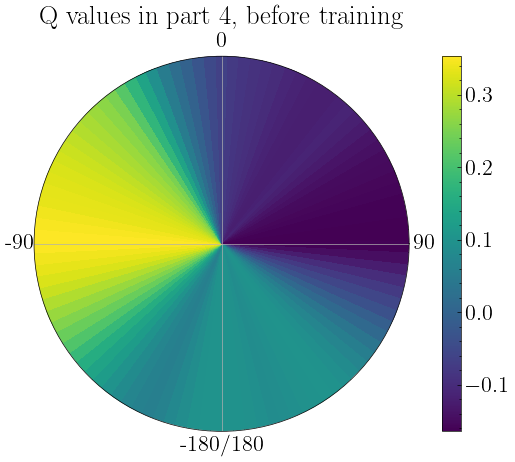

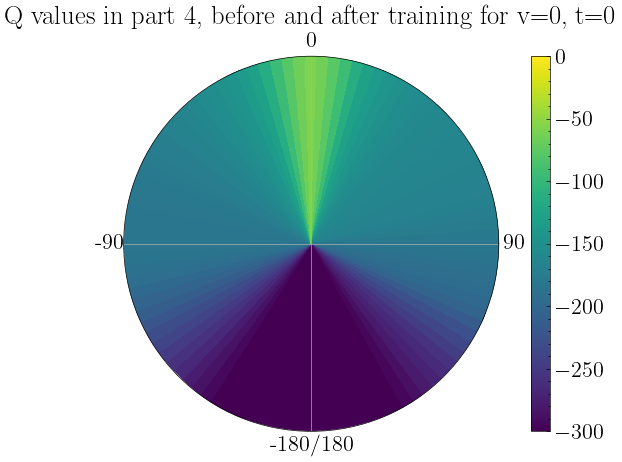

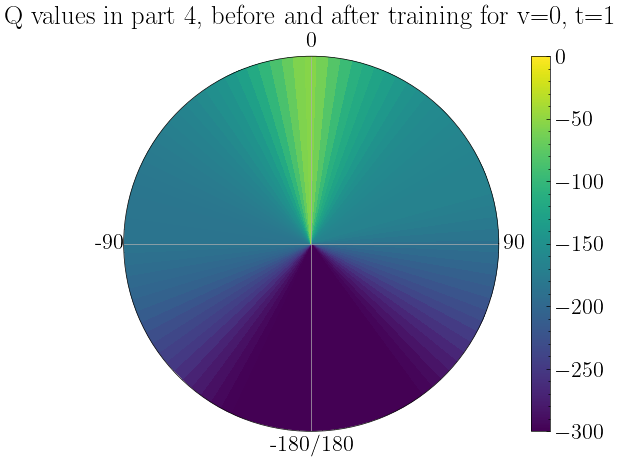

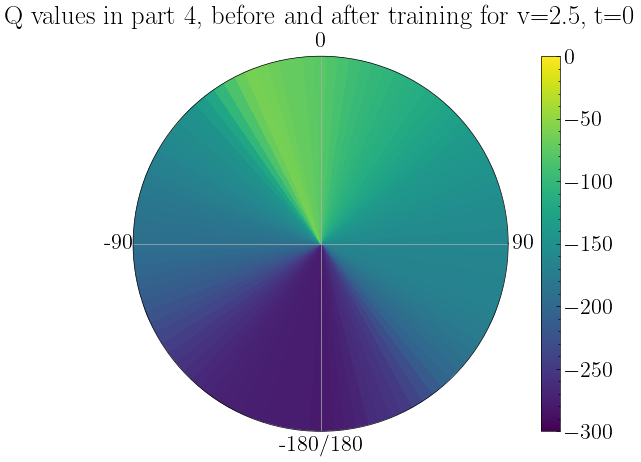

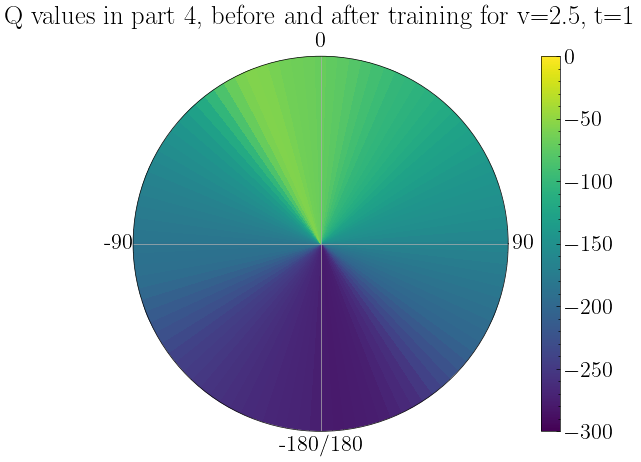

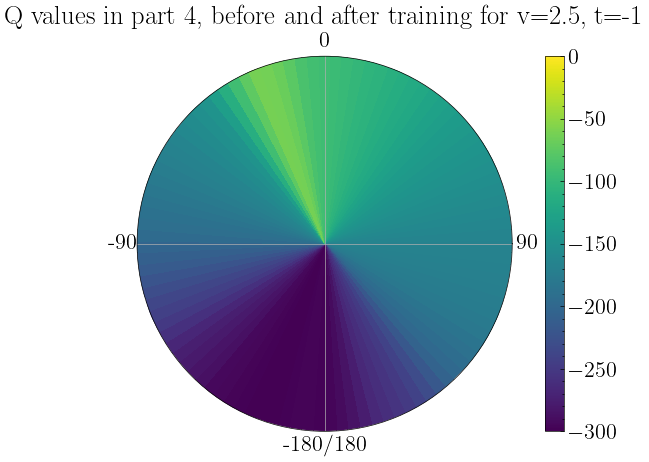

In [36]:
plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize=(7, 5))
polar_heatmap(qnetwork_part4_before_training, 0, 0, colorbar=True, clim=None)
plt.savefig("figures/qvalues_part4_before_training.png", bbox_inches="tight", dpi=300)
plt.title("Q values in part 4, before training")
plt.tight_layout()
for v, t in [(0, 0), (0, 1), (2.5, 0), (2.5, 1), (2.5, -1)]:
    plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize=(7, 5))
    polar_heatmap(qnetwork_part4, v, t, colorbar=True, clim=(-300, 0))
    plt.savefig(f"figures/qvalues_part4_v{v}_t{t}.png", bbox_inches="tight", dpi=300)
    plt.title(f"Q values in part 4, before and after training for v={v}, t={t}")
    plt.tight_layout()

# Part 5: Minimal implementation of DDPG

In [37]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh(),
        )
        # intialize weights with xavier uniform
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [38]:
class GaussianActionNoise:
    def __init__(self, sigma: float) -> None:
        self.sigma = sigma

    def get_noisy_action(
        self, action: Union[np.ndarray, torch.Tensor]
    ) -> Union[np.ndarray, torch.Tensor]:
        if isinstance(action, np.ndarray):
            return np.clip(
                action + np.random.normal(0, self.sigma, size=action.shape), -1, 1
            )
        else:
            return torch.clip(
                action + torch.normal(0, self.sigma, size=action.shape), -1, 1
            )

In [39]:
class DDPGAgent(Agent):
    def __init__(self, policy_network: PolicyNetwork, noise: GaussianActionNoise):
        self.policy_network = policy_network
        self.noise = noise

    def compute_action(self, state: torch.Tensor, deterministic=True) -> torch.Tensor:
        state = torch.atleast_2d(state).float()
        if deterministic:
            return self.policy_network(state)
        else:
            return self.noise.get_noisy_action(self.policy_network(state))

In [40]:
def actor_learning_step(
    actor: DDPGAgent, critic: QNetwork, batch: tuple, optimizer: torch.optim.Optimizer
) -> float:
    states, _, _, _, _ = batch
    states = torch.from_numpy(states).float()
    # compute loss
    loss = -critic(
        torch.hstack((states, actor.compute_action(states, deterministic=False)))
    ).mean()

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def critic_learning_step(
    actor: DDPGAgent,
    critic: QNetwork,
    batch: tuple,
    optimizer: torch.optim.Optimizer,
    gamma: float,
) -> float:
    states, actions, rewards, next_states, truncs = batch

    # compute the target
    with torch.no_grad():
        next_states = torch.from_numpy(next_states).float()
        next_actions = actor.compute_action(next_states, deterministic=False)
        next_q_values = critic(torch.hstack((next_states, next_actions))).squeeze()
        target = (
            torch.from_numpy(rewards).float()
            + gamma * next_q_values * ~torch.from_numpy(truncs).bool()
        )

    # compute q values using qnetwork
    states = torch.from_numpy(states).float()
    actions = torch.from_numpy(actions).float().unsqueeze(1)
    q_values = critic(torch.hstack((states, actions))).squeeze()

    # compute loss
    loss = F.mse_loss(q_values, target)

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train_ddpg(
    env: NormalizedEnv,
    agent: DDPGAgent,
    qnetwork: QNetwork,
    num_episodes=1000,
    batch_size=128,
    buffer_size=1e4,
    gamma=0.99,
    learning_rate=1e-4,
) -> tuple[list[float], list[float], list[float]]:
    buffer = ReplayBuffer(int(buffer_size))
    critic_optimizer = optim.Adam(qnetwork.parameters(), lr=learning_rate)
    assert hasattr(agent, "policy_network") and isinstance(
        agent.policy_network, PolicyNetwork
    )
    actor_optimizer = optim.Adam(agent.policy_network.parameters(), lr=learning_rate)

    critic_losses = []
    actor_losses = []
    cumulated_rewards = []
    for _ in tqdm.trange(num_episodes):
        # run an episode with the agent
        state = env.reset()[0]
        trunc = False
        critic_episode_losses = []
        actor_episode_losses = []
        cumulated_reward = 0
        while not trunc:
            # compute action and perform a step in the environment
            with torch.no_grad():
                action = agent.compute_action(
                    torch.from_numpy(state).float(), deterministic=False
                )
                action = action[0, 0].item()
            next_state, reward, _, trunc, _ = env.step(action)
            buffer.append(state, action, reward, next_state, trunc)
            state = next_state
            cumulated_reward += reward

            if len(buffer) < batch_size:
                continue

            # critic learning step
            # bootstrap the buffer
            qnetwork.train()
            agent.policy_network.eval()
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            critic_episode_losses.append(
                critic_learning_step(
                    agent, qnetwork, buffer.sample(indices), critic_optimizer, gamma
                )
            )

            # actor learning step
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            qnetwork.eval()
            agent.policy_network.train()
            actor_episode_losses.append(
                actor_learning_step(
                    agent, qnetwork, buffer.sample(indices), actor_optimizer
                )
            )

        critic_losses.append(np.mean(critic_episode_losses))
        actor_losses.append(np.mean(actor_episode_losses))
        cumulated_rewards.append(cumulated_reward)

    return critic_losses, actor_losses, cumulated_rewards

In [42]:
qnetwork_part5 = QNetwork()
qnetwork_part5_before_training = QNetwork()
qnetwork_part5_before_training.load_state_dict(qnetwork_part5.state_dict())
policy_network_part5 = PolicyNetwork()
policy_network_part5_before_training = PolicyNetwork()
policy_network_part5_before_training.load_state_dict(policy_network_part5.state_dict())
noise_std = 0.3
agent = DDPGAgent(policy_network_part5, GaussianActionNoise(noise_std))
critic_losses_part5, actor_losses_part5, cumulated_rewards_part5 = train_ddpg(
    env,
    agent,
    qnetwork_part5,
    learning_rate=1e-4,
    batch_size=128,
    gamma=0.99,
    buffer_size=1e5,
)

100%|██████████| 1000/1000 [03:43<00:00,  4.46it/s]


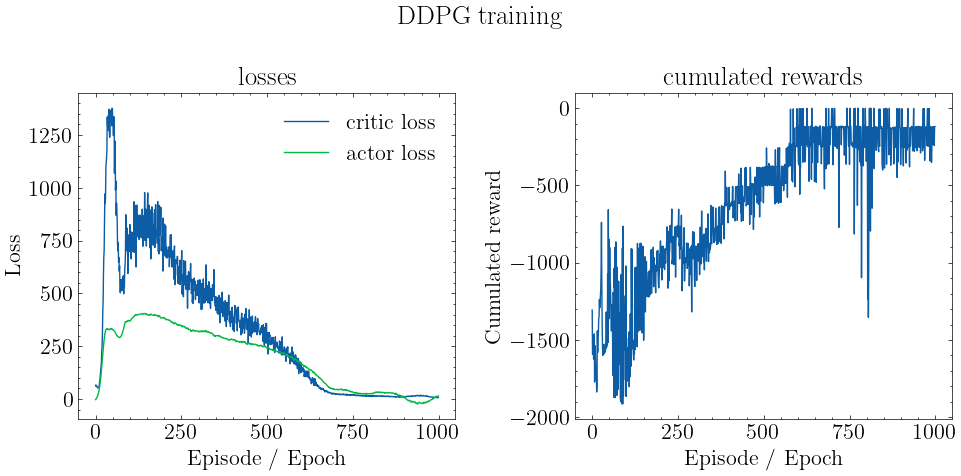

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(critic_losses_part5, label="critic loss")
plt.plot(actor_losses_part5, label="actor loss")
plt.xlabel("Episode / Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("losses")
plt.subplot(1, 2, 2)
plt.plot(cumulated_rewards_part5)
plt.xlabel("Episode / Epoch")
plt.ylabel("Cumulated reward")
plt.title("cumulated rewards")
plt.tight_layout()
plt.savefig("figures/losses_part5.png", dpi=300, bbox_inches="tight")
plt.suptitle("DDPG training")
plt.tight_layout()

In [46]:
np.mean(cumulated_rewards_part5[600:])

-195.33273339274106

In [44]:
policy_network_part5.eval()
policy_network_part5_before_training.eval()
with torch.no_grad():
    mean_reward_part5_after_training = np.mean(
        [
            np.sum(
                run_episode(
                    env, DDPGAgent(policy_network_part5, GaussianActionNoise(sigma=0.3))
                )
            )
            for _ in range(100)
        ]
    )
    mean_reward_part5_before_training = np.mean(
        [
            np.sum(
                run_episode(
                    env,
                    DDPGAgent(
                        policy_network_part5_before_training,
                        GaussianActionNoise(sigma=0.3),
                    ),
                )
            )
            for _ in range(100)
        ]
    )
print(
    "Mean reward before DDPG training (part5): ",
    mean_reward_part5_before_training,
)
print(
    "Mean reward after DDPG training (part5): ",
    mean_reward_part5_after_training,
)

Mean reward before DDPG training (part5):  -1551.1389960102686
Mean reward after DDPG training (part5):  -152.54171272979883


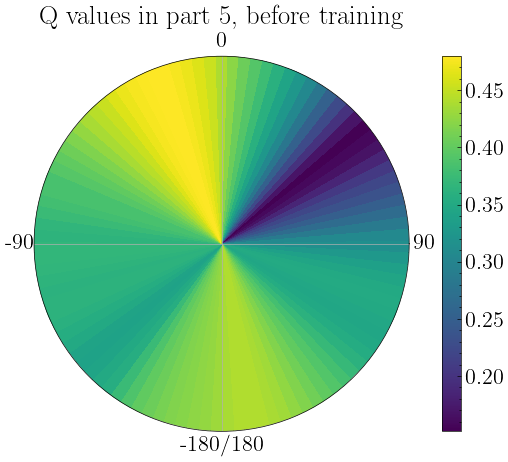

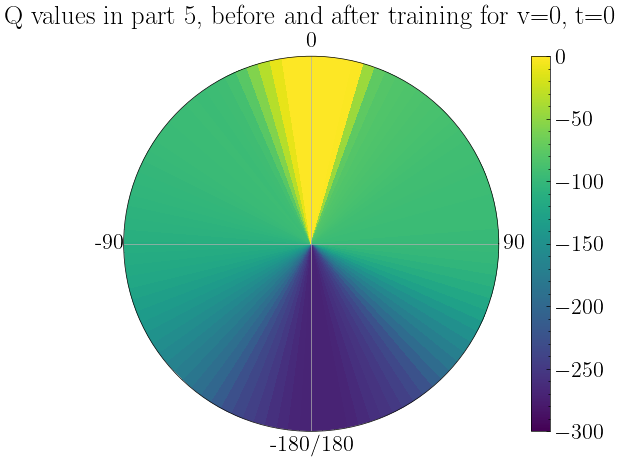

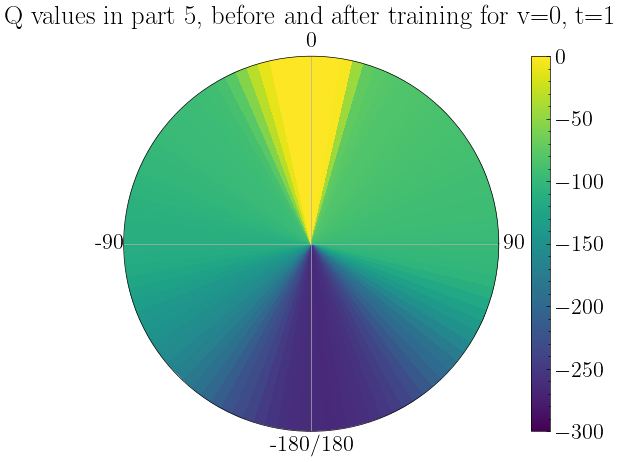

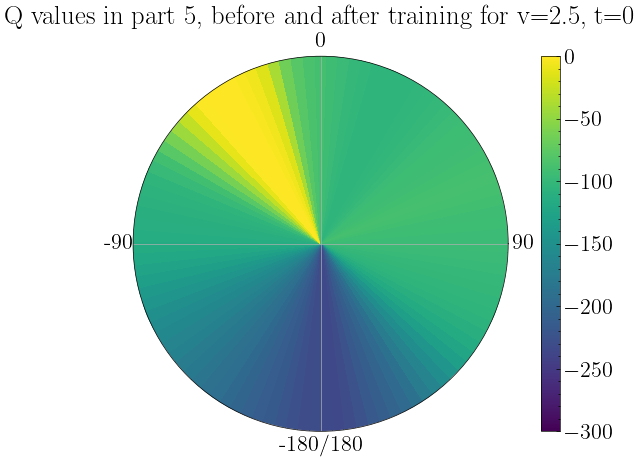

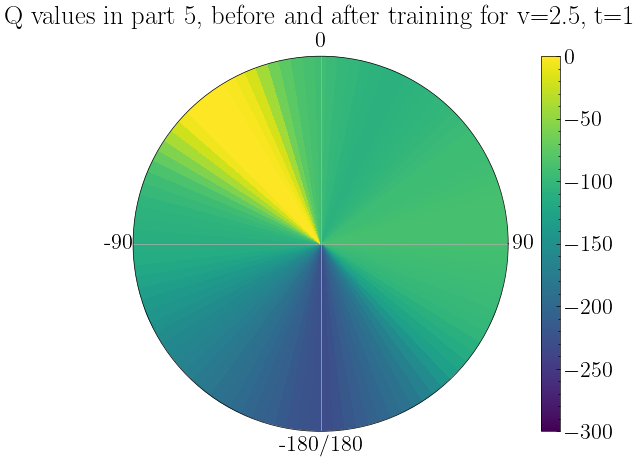

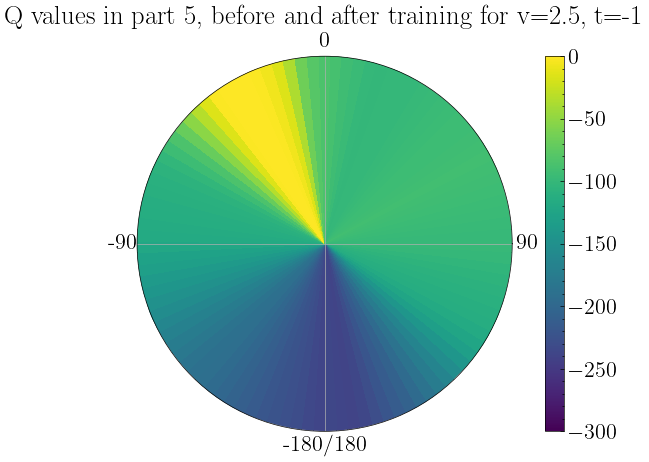

In [45]:
plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize=(7, 5))
polar_heatmap(qnetwork_part5_before_training, 0, 0, colorbar=True, clim=None)
plt.savefig("figures/qvalues_part5_before_training.png", bbox_inches="tight", dpi=300)
plt.title("Q values in part 5, before training")
plt.tight_layout()
for v, t in [(0, 0), (0, 1), (2.5, 0), (2.5, 1), (2.5, -1)]:
    plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize=(7, 5))
    polar_heatmap(qnetwork_part5, v, t, colorbar=True, clim=(-300, 0))
    plt.savefig(f"figures/qvalues_part5_v{v}_t{t}.png", bbox_inches="tight", dpi=300)
    plt.title(f"Q values in part 5, before and after training for v={v}, t={t}")
    plt.tight_layout()

# Part 6: Target networks

In [24]:
class DDPGAgentWithTargetNetwork(DDPGAgent):
    def __init__(self, policy_network: PolicyNetwork, noise: GaussianActionNoise):
        super().__init__(policy_network, noise)
        self.target_policy_network = PolicyNetwork()
        self.target_policy_network.load_state_dict(self.policy_network.state_dict())

In [25]:
def actor_learning_step_part6(
    actor: DDPGAgentWithTargetNetwork,
    critic: QNetwork,
    batch: tuple,
    optimizer: torch.optim.Optimizer,
) -> float:
    states, _, _, _, _ = batch
    states = torch.from_numpy(states).float()

    # compute loss
    loss = -critic(
        torch.hstack((states, actor.compute_action(states, deterministic=False)))
    ).mean()

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def critic_learning_step_part6(
    actor: DDPGAgent,
    critic: QNetwork,
    batch: tuple,
    optimizer: torch.optim.Optimizer,
    gamma: float,
) -> float:
    states, actions, rewards, next_states, truncs = batch

    # compute the target
    with torch.no_grad():
        next_states = torch.from_numpy(next_states).float()
        next_actions = actor.compute_action(next_states, deterministic=False)
        next_q_values = critic(torch.hstack((next_states, next_actions))).squeeze()
        target = (
            torch.from_numpy(rewards).float()
            + gamma * next_q_values * ~torch.from_numpy(truncs).bool()
        )

    # compute q values using qnetwork
    states = torch.from_numpy(states).float()
    actions = torch.from_numpy(actions).float().unsqueeze(1)
    q_values = critic(torch.hstack((states, actions))).squeeze()

    # compute loss
    loss = F.mse_loss(q_values, target)

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train_ddpg_with_target(
    env: NormalizedEnv,
    agent: DDPGAgentWithTargetNetwork,
    qnetwork: QNetwork,
    target_qnetwork: QNetwork,
    tau: float,
    num_episodes=1000,
    batch_size=128,
    buffer_size=1e4,
    gamma=0.99,
    learning_rate=1e-4,
) -> tuple[list[float], list[float], list[float]]:
    buffer = ReplayBuffer(int(buffer_size))
    critic_optimizer = optim.Adam(qnetwork.parameters(), lr=learning_rate)
    assert hasattr(agent, "policy_network") and isinstance(
        agent.policy_network, PolicyNetwork
    )
    actor_optimizer = optim.Adam(agent.policy_network.parameters(), lr=learning_rate)

    critic_losses = []
    actor_losses = []
    cumulated_rewards = []
    for _ in tqdm.trange(num_episodes):
        # run an episode with the agent
        state = env.reset()[0]
        trunc = False
        critic_episode_losses = []
        actor_episode_losses = []
        cumulated_reward = 0
        while not trunc:
            # compute action and perform a step in the environment
            with torch.no_grad():
                action = agent.compute_action(
                    torch.from_numpy(state).float(), deterministic=False
                )
                action = action[0, 0].item()
            next_state, reward, _, trunc, _ = env.step(action)
            buffer.append(state, action, reward, next_state, trunc)
            state = next_state
            cumulated_reward += reward

            if len(buffer) < batch_size:
                continue

            # critic learning step
            # bootstrap the buffer
            qnetwork.train()
            agent.policy_network.eval()
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            critic_episode_losses.append(
                critic_learning_step_part6(
                    agent, qnetwork, buffer.sample(indices), critic_optimizer, gamma
                )
            )

            # actor learning step
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            qnetwork.eval()
            agent.policy_network.train()
            actor_episode_losses.append(
                actor_learning_step_part6(
                    agent, qnetwork, buffer.sample(indices), actor_optimizer
                )
            )

        critic_losses.append(np.mean(critic_episode_losses))
        actor_losses.append(np.mean(actor_episode_losses))
        cumulated_rewards.append(cumulated_reward)

        # update target networks (one in DDPGAgent and the atrget_qnetwork) with soft updates
        for target_param, param in zip(
            agent.target_policy_network.parameters(), agent.policy_network.parameters()
        ):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(
            target_qnetwork.parameters(), qnetwork.parameters()
        ):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    return critic_losses, actor_losses, cumulated_rewards

In [27]:
taus = [0.01, 0.1, 0.5, 0.9, 1.0]
critic_losses_part6 = {}
actor_losses_part6 = {}
cumulated_rewards_part6 = {}
policies_before_training_part6 = {}
policies_after_training_part6 = {}
qnetworks_after_training_part6 = {}
for tau in taus:
    qnetwork = QNetwork()
    target_qnetwork = QNetwork()
    target_qnetwork.load_state_dict(qnetwork.state_dict())
    policy_network = PolicyNetwork()
    policies_before_training_part6[tau] = PolicyNetwork()
    policies_before_training_part6[tau].load_state_dict(policy_network.state_dict())
    noise_std = 0.3
    agent = DDPGAgentWithTargetNetwork(policy_network, GaussianActionNoise(noise_std))
    (
        critic_losses_part6[tau],
        actor_losses_part6[tau],
        cumulated_rewards_part6[tau],
    ) = train_ddpg_with_target(
        env,
        agent,
        qnetwork,
        target_qnetwork,
        tau=tau,
        learning_rate=1e-4,
        batch_size=128,
        gamma=0.99,
        buffer_size=1e5,
    )
    policies_after_training_part6[tau] = agent.policy_network
    qnetworks_after_training_part6[tau] = qnetwork

100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


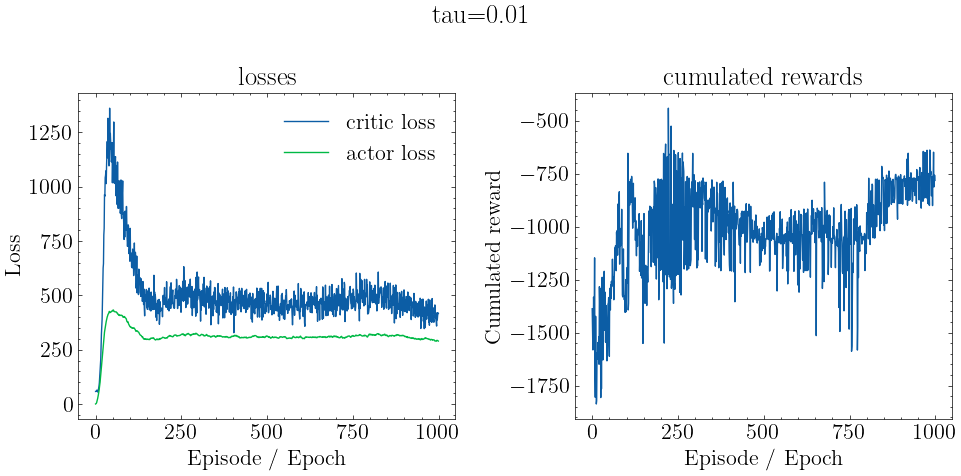

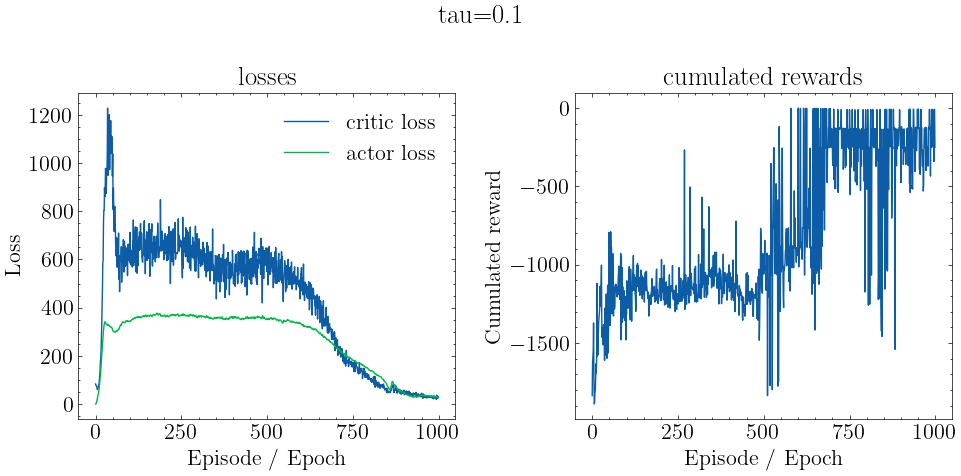

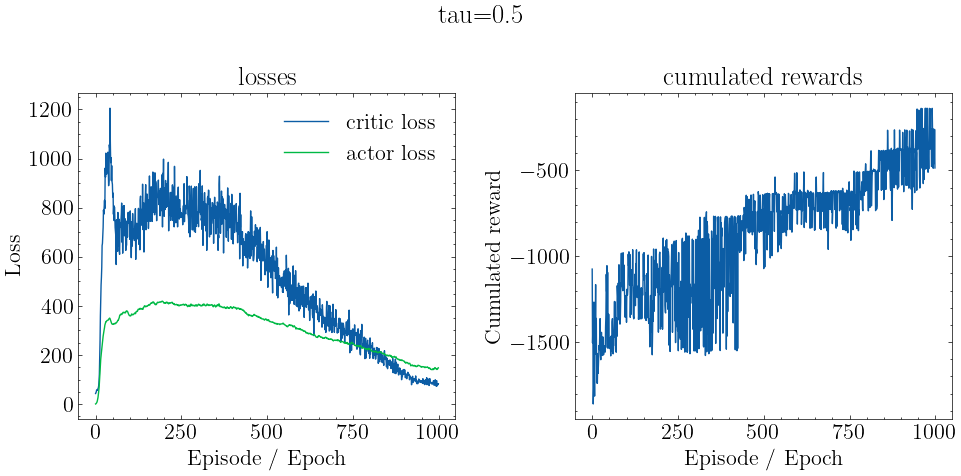

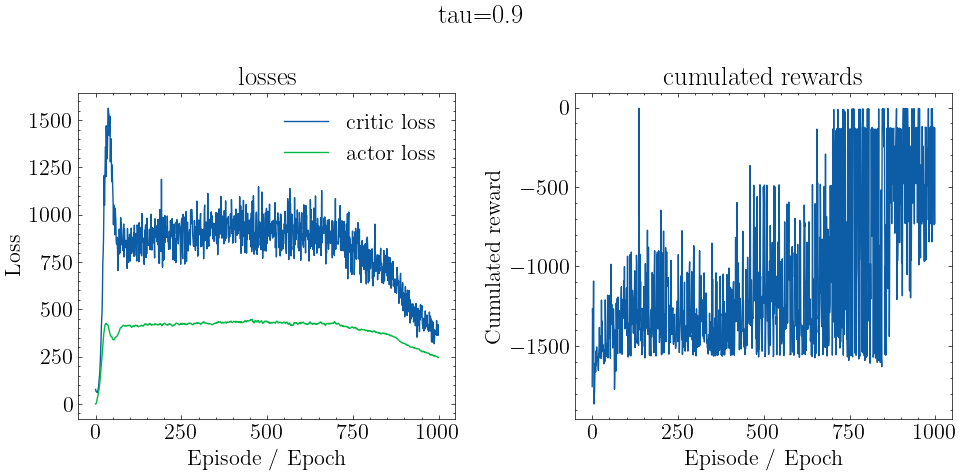

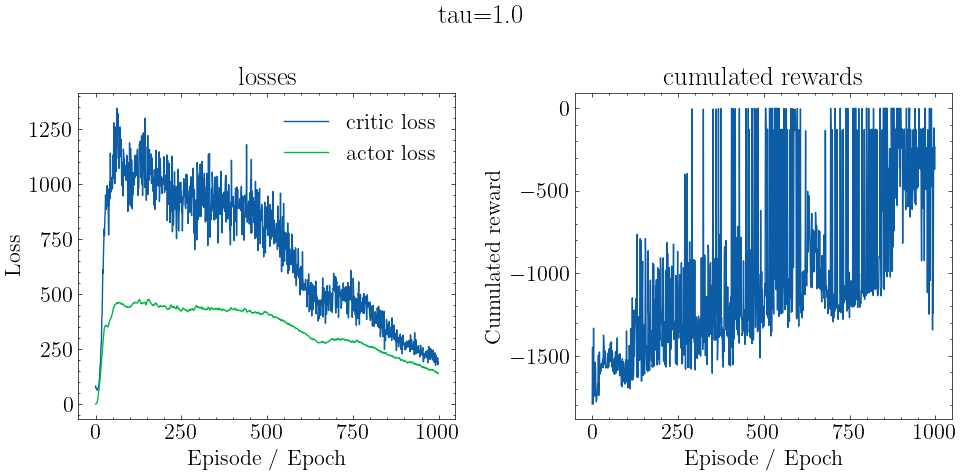

In [28]:
for tau in taus:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(critic_losses_part6[tau], label="critic loss")
    plt.plot(actor_losses_part6[tau], label="actor loss")
    plt.xlabel("Episode / Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("losses")
    plt.subplot(1, 2, 2)
    plt.plot(cumulated_rewards_part6[tau])
    plt.xlabel("Episode / Epoch")
    plt.ylabel("Cumulated reward")
    plt.title("cumulated rewards")
    plt.tight_layout()
    plt.savefig(f"figures/losses_part6_tau={tau}.png", dpi=300, bbox_inches="tight")
    plt.suptitle(f"tau={tau}")
    plt.tight_layout()

In [29]:
for tau in taus:
    policies_after_training_part6[tau].eval()
    policies_before_training_part6[tau].eval()

mean_reward_part6_after_training = {
    tau: np.mean(
        [
            np.sum(
                run_episode(
                    env, DDPGAgent(policies_after_training_part6[tau], GaussianActionNoise(sigma=0.3))
                )
            )
            for _ in range(100)
        ]
    )
    for tau in taus
}
mean_reward_part6_before_training = {
    tau: np.mean(
        [
            np.sum(
                run_episode(
                    env, DDPGAgent(policies_before_training_part6[tau], GaussianActionNoise(sigma=0.3))
                )
            )
            for _ in range(100)
        ]
    )
    for tau in taus
}

for tau in taus:
    print(
        f"Mean reward before DDPG training (part6) with tau={tau}: {mean_reward_part6_before_training[tau]}"
    )
    print(
        f"Mean reward after DDPG training (part6) with tau={tau}: {mean_reward_part6_after_training[tau]}"
    )

Mean reward before DDPG training (part6) with tau=0.01: -1337.6218765819367
Mean reward after DDPG training (part6) with tau=0.01: -728.108583046547
Mean reward before DDPG training (part6) with tau=0.1: -1712.1135942695316
Mean reward after DDPG training (part6) with tau=0.1: -158.7493365407932
Mean reward before DDPG training (part6) with tau=0.5: -1331.3981227213005
Mean reward after DDPG training (part6) with tau=0.5: -221.45184731809056
Mean reward before DDPG training (part6) with tau=0.9: -1640.1631936150304
Mean reward after DDPG training (part6) with tau=0.9: -444.88729743276747
Mean reward before DDPG training (part6) with tau=1.0: -1432.944792191716
Mean reward after DDPG training (part6) with tau=1.0: -454.104364581593


# Part 7: Ornstein-Uhlenbeck noise

In [30]:
class OUActionNoise:
    def __init__(self, sigma: float, theta: float):
        self.sigma = sigma
        self.theta = theta
        # we don't initialize here because we don't know the shape (in particular the 
        # batch size) or the type (np.ndarray or torch.Tensor) of the action yet
        self.noise = None  

    def get_noisy_action(
        self, action: Union[np.ndarray, torch.Tensor]
    ) -> Union[np.ndarray, torch.Tensor]:
        if self.noise is None:
            self.noise = (
                np.zeros_like(action)
                if isinstance(action, np.ndarray)
                else torch.zeros_like(action)
            )
        if isinstance(action, np.ndarray):
            self.noise = (
                1 - self.theta
            ) * self.noise + self.sigma * np.random.randn(*action.shape)
            return np.clip(action + self.noise, -1, 1)
        else:
            self.noise = (
                1 - self.theta
            ) * self.noise + self.sigma * torch.randn(*action.shape)
            return torch.clip(action + self.noise, -1, 1)

In [32]:
thetas = [0.0, 0.1, 0.5, 0.9, 1.0]
tau = 0.1
noise_std = 0.3
critic_losses_part7 = {}
actor_losses_part7 = {}
cumulated_rewards_part7 = {}
policies_before_training_part7 = {}
policies_after_training_part7 = {}
qnetworks_after_training_part7 = {}
for theta in thetas:
    qnetwork = QNetwork()
    target_qnetwork = QNetwork()
    target_qnetwork.load_state_dict(qnetwork.state_dict())
    policy_network = PolicyNetwork()
    policies_before_training_part7[theta] = PolicyNetwork()
    policies_before_training_part7[theta].load_state_dict(policy_network.state_dict())
    agent = DDPGAgentWithTargetNetwork(policy_network, OUActionNoise(sigma=noise_std, theta=theta))
    (
        critic_losses_part7[theta],
        actor_losses_part7[theta],
        cumulated_rewards_part7[theta],
    ) = train_ddpg_with_target(
        env,
        agent,
        qnetwork,
        target_qnetwork,
        tau=tau,
        learning_rate=1e-4,
        batch_size=128,
        gamma=0.99,
        buffer_size=1e5,
    )
    policies_after_training_part7[theta] = agent.policy_network
    qnetworks_after_training_part7[theta] = qnetwork

100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


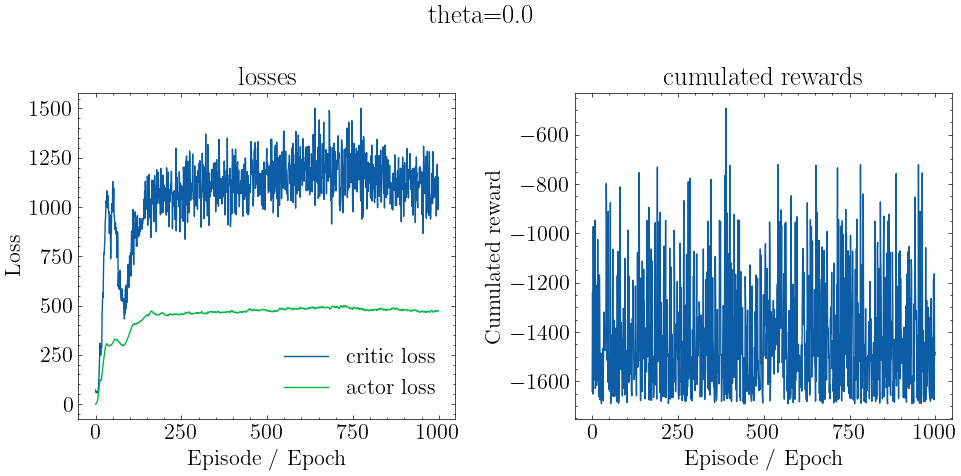

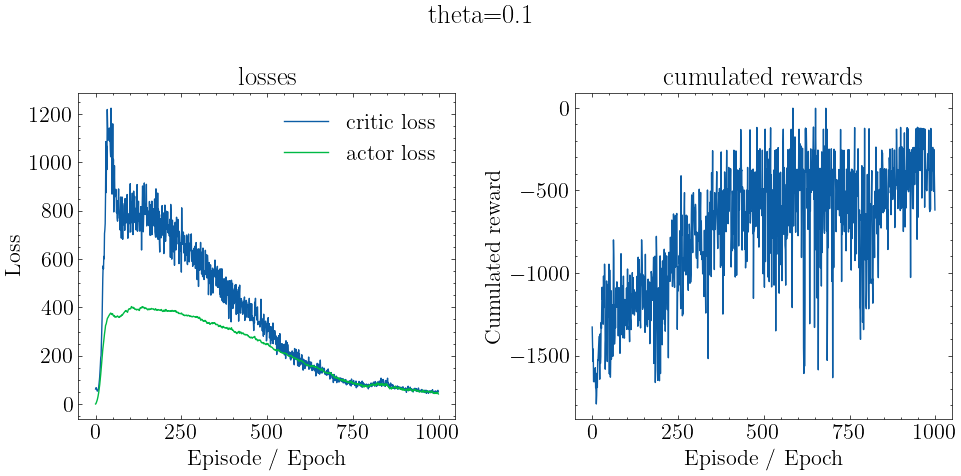

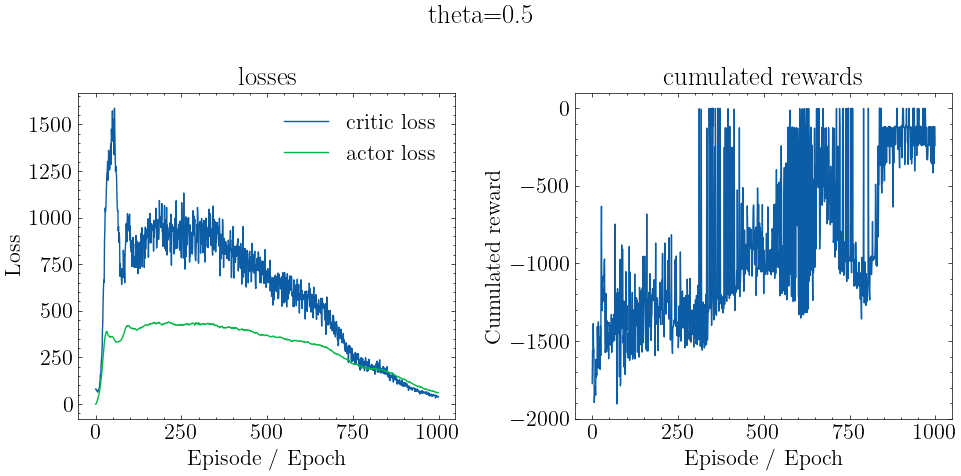

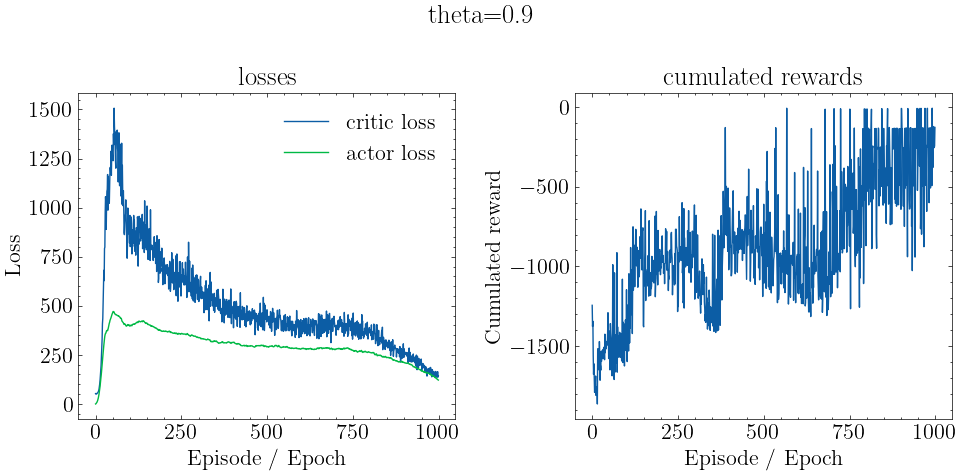

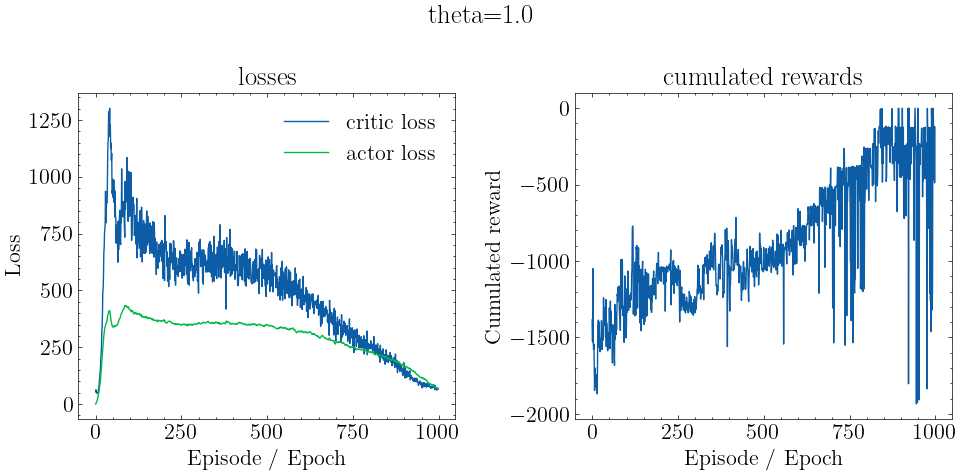

In [33]:
for theta in thetas:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(critic_losses_part7[theta], label="critic loss")
    plt.plot(actor_losses_part7[theta], label="actor loss")
    plt.xlabel("Episode / Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("losses")
    plt.subplot(1, 2, 2)
    plt.plot(cumulated_rewards_part7[theta])
    plt.xlabel("Episode / Epoch")
    plt.ylabel("Cumulated reward")
    plt.title("cumulated rewards")
    plt.tight_layout()
    plt.savefig(f"figures/losses_part7_theta={theta}.png", dpi=300, bbox_inches="tight")
    plt.suptitle(f"theta={theta}")
    plt.tight_layout()

In [34]:
for theta in thetas:
    policies_after_training_part7[theta].eval()
    policies_before_training_part7[theta].eval()

mean_reward_part7_after_training = {
    theta: np.mean(
        [
            np.sum(
                run_episode(
                    env, DDPGAgent(policies_after_training_part7[theta], GaussianActionNoise(sigma=0.3))
                )
            )
            for _ in range(100)
        ]
    )
    for theta in thetas
}
mean_reward_part7_before_training = {
    theta: np.mean(
        [
            np.sum(
                run_episode(
                    env, DDPGAgent(policies_before_training_part7[theta], GaussianActionNoise(sigma=0.3))
                )
            )
            for _ in range(100)
        ]
    )
    for theta in thetas
}

for theta in thetas:
    print(
        f"Mean reward before DDPG training (part7) with theta={theta}: {mean_reward_part7_before_training[theta]}"
    )
    print(
        f"Mean reward after DDPG training (part7) with theta={theta}: {mean_reward_part7_after_training[theta]}"
    )

Mean reward before DDPG training (part7) with theta=0.0: -1611.6397876679705
Mean reward after DDPG training (part7) with theta=0.0: -599.0025022113315
Mean reward before DDPG training (part7) with theta=0.1: -1412.2612065596386
Mean reward after DDPG training (part7) with theta=0.1: -136.5174534397713
Mean reward before DDPG training (part7) with theta=0.5: -1574.4685634826099
Mean reward after DDPG training (part7) with theta=0.5: -147.84698086259698
Mean reward before DDPG training (part7) with theta=0.9: -1432.1862696924818
Mean reward after DDPG training (part7) with theta=0.9: -316.7916247847445
Mean reward before DDPG training (part7) with theta=1.0: -1541.4735677164128
Mean reward after DDPG training (part7) with theta=1.0: -463.81557917297846
